In [51]:
import pandas as pd
import sqlite3
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
load_dotenv()

True

### Evaluate Evidence Instruction Following
1. Did the model always extract an excerpt when making a positive classification?
2. Did the model incorrectly extract an exctract when making a negative classifiction?
3. Are extracted excerpts found in the original text?

In [2]:
qry = """
SELECT co.ROWID, co.comment_text, cl.is_possible_delusion, cl.excerpt, cl.prompt_tokens FROM classifications cl
INNER JOIN comments co ON cl.input_text_id = co.ROWID
WHERE cl.prompt_version = 5
"""
llm_class_df = pd.read_sql(qry, con=sqlite3.connect(os.path.join('..', 'data', os.getenv('SQLITE_DB_NAME'))))
llm_class_df.shape

(1337, 5)

In [68]:
is_positive = llm_class_df['is_possible_delusion'] == 1
llm_class_df["comment_text_clean"] = llm_class_df["comment_text"].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.lower()
llm_class_df["excerpt_clean"] = llm_class_df["excerpt"].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.lower() # added lower
llm_class_df.loc[llm_class_df.excerpt == "N/A", "excerpt_clean"] = None
llm_class_df["excerpt_clean_len"] = llm_class_df["excerpt_clean"].str.len()
llm_class_df["excerpt_in_comment"] = llm_class_df.apply(lambda row: row["excerpt_clean"] in row["comment_text_clean"] if row["excerpt_clean"] else None, axis=1)

def get_substrings_len_k(string, k):
    return [string[i:i+int(k)] for i in range(len(string)-int(k)+1)]

llm_class_df["comment_text_clean_substr"] = llm_class_df.apply(lambda x: get_substrings_len_k(x["comment_text_clean"], x["excerpt_clean_len"]) if pd.notnull(x["excerpt_clean_len"]) else None, axis=1)
def max_substr_ratio(row):
    if row["comment_text_clean_substr"] is None:
        return None
    else:
        return max([difflib.SequenceMatcher(None, row["excerpt_clean"], s).ratio() for s in row["comment_text_clean_substr"]])
llm_class_df["max_diff_ratio"] = llm_class_df.apply(lambda x: max_substr_ratio(x), axis=1)

##### 1. Did the model always extract an excerpt when making a positive classification?
Yes, it appears so.

In [137]:
llm_class_df["has_excerpt"] = llm_class_df["excerpt_clean"].notnull()
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 1, "has_excerpt"].value_counts())
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 1, "has_excerpt"].value_counts(normalize=True))

True    289
Name: has_excerpt, dtype: int64
True    1.0
Name: has_excerpt, dtype: float64


##### 2. Did the model incorrectly extract an exctract when making a negative classifiction?
Incorrectly extracted an excpert 9% of the time

In [138]:
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 0, "has_excerpt"].value_counts())
print(llm_class_df.loc[llm_class_df.is_possible_delusion == 0, "has_excerpt"].value_counts(normalize=True))

False    956
True     91 
Name: has_excerpt, dtype: int64
False    0.913085
True     0.086915
Name: has_excerpt, dtype: float64


##### 3. Are extracted excerpts found in the text?
This is a more nuanced answer. 83% of the time, the original string (remove case and punc) was found in the original text.

In [140]:
llm_class_df_has_excerpt = llm_class_df.loc[llm_class_df.has_excerpt == True]
print(llm_class_df_has_excerpt.excerpt_in_comment.value_counts())
print(llm_class_df_has_excerpt.excerpt_in_comment.value_counts(normalize=True))

True     316
False    64 
Name: excerpt_in_comment, dtype: int64
True     0.831579
False    0.168421
Name: excerpt_in_comment, dtype: float64



#### Max Similarity >0.9
When calculuating a maximum diff ratio for substrings of equal length to the extracted excerpt, observe that nearly *25% have a string similarity over 0.9*. Inspecting a sample shows illustrates that the errors are not very meaningful to the excerpt task:
- Addition of a pronoun where the original text has none. For example "but has 1 or 2 delusions a month" --> "she but has 1 or 2 delusions a month".
- Correction of a spelling error. For example, "sit there and cpunt the people" --> "sit there and count the people"

We'll call these low severity errors... It would be fairly simple, albiet computationally expensive, to write a program to compares the excerpt in the original text and extract the correct excerpt, without modification.

#### Max Similarity Between 0.7 and 0.9
- Combination of two non-contiguous portions of the original text. Sometimes adding a [...] in between.
- Filling in an implicit statement, such as "thinks he can \[drive\]"
- A few cases in which I somehow failed to remove new line characters
- Some major whiffs, where just "None" was extracted. This has a high similarity score when compared to small words.


#### Max Similarity <0.5
Max similarity less than 0.5, which accounts for ~40% of cases, appears to be "hallucinating" in some cases, or regurgitating examples from the prompt.

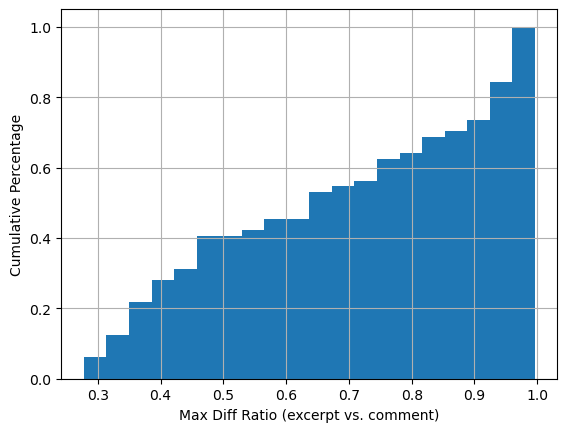

In [118]:
excerpt_not_in_comment = ~llm_class_df_has_excerpt.excerpt_in_comment.astype(bool)
llm_class_df_has_excerpt.loc[excerpt_not_in_comment, "max_diff_ratio"].hist(bins=20, cumulative=True, density=True)
plt.ylabel("Cumulative Percentage")
plt.xlabel("Max Diff Ratio (excerpt vs. comment)")
plt.show()

In [125]:
llm_class_df_has_excerpt.loc[excerpt_not_in_comment & (llm_class_df_has_excerpt.max_diff_ratio > 0.90), ["comment_text", "excerpt", "max_diff_ratio"]].sample(10)

,comment_text,excerpt,max_diff_ratio
1196,"PERSON quarantine was the worst time of my life, not only because I couldn't go out, because my granfather with alzheimer and cancer was on my house, and we were the only ones that for the previous 2 years could take care of him. I remember he starting to forget everyone, however, more than forget, he usually took others as sombody that he previusly know, however, I was the only one that everyday, I was a stranger to himself. As his diseasess sarted to advance, it was clear that this month, was his last, however, an unexpected event happened. My other grandfather died suddenly, because of covid, I didn't even knew that he catched something and felt all surreal. The days passed and as well my grandpa with dementia, and... the first day I could handle the pain of all, the anxiety that I was coming through but one night I have a dream. It was simple, and even.. felt like a normal day, I went out with my friends, having a great time. However, when I got to my house, I found My grandfather, standing and smiling and the only thing that I did was hugging him. I swear that when I did that, I felt the warm of his body, and no long after, I woke up crying, without knowing what happened. After that magical event, I started to feel more relieved, at least, he wasn't living in that manner anymore and... That dream felt like the farewell that I needed. This video made me remember of that rough time, and the only thing that I can do is express my story and beeing up to help and listen all the families that are coming through this","""My grandfather with alzheimer and cancer was on my house, and we were the only ones that for the previous 2 years could take care of him. I remember he starting to forget everyone, however, more than forget, he usually took others as sombody that he previusly know, however, I was the only one that everyday, I was a stranger to himself.""",0.996255
331,"Oh, come on, for the second tip, where he wants to take off to work it is better to say "" OK Dad, take a shower and get ready I will prepare your lunch and drive you there. Then half-way exclaim. ""Oh Dad I am so sorry I forgot to tell you that today is a holiday, so let's go bowling instead.\nHaha, If you think I am condescending heartless bloke, just relax. I am 73 and well into the first stage of dementia 4 years and counting.\nObviously I can still type, but have no idea what day it is, or where I put my shoes.","""I have no idea what day it is, or where I put my shoes.""",0.975000
494,"My grandmother is 86 and she's going through the same problem she gets so much aggressive and starts beating and abusing everyone in the house and keep asking to go home and hallucinate the things as well but now her condition is getting more down day by day..she can't go to toilet by her own, she even get nude sometimes I don't know what should I do now??","""she keeps asking to go home and hallucinate the things as well""",0.941176
235,"My aunt says a lot of things that are so outrageous. \nA) her dog was poisoned ( when in fact she went to the vets to have her dog put down with a trusted friend)\nB) she says her neighbour is crazy a and has been ringer doorbell at 7am several times \nC) I’ve had three stokes\nAt first I thought ok she misunderstood a sound? ( door bell or TV )\nShe had guilt over her dog, so makes up a story to handle her grief\nHas been having a few pains in her head, and or headaches, calls them a stroke?\nDoes this all come from nowhere? Or do you think I’m on the right track?","""She says her neighbour is crazy and has been ringing her doorbell at 7am several times""",0.943662
405,"Oh my gosh - I was very new to nursing and had a lovely lady who asked me when her husband was going to visit. Sadly he had been dead for quite a while and in my wish to be truthful, told her so. How I wish I hadn’t. She became distressed and couldn’t believe I would tell such a cruel lie. I never made that mistake again. Just a few 

In [126]:
llm_class_df_has_excerpt.loc[excerpt_not_in_comment
                 & (llm_class_df_has_excerpt.max_diff_ratio > 0.70) 
                 & (llm_class_df_has_excerpt.max_diff_ratio < 0.90), 
                 ["comment_text", "excerpt", "max_diff_ratio"]].sample(10).sort_values("max_diff_ratio")


,comment_text,excerpt,max_diff_ratio
592,My husband is the same way none stop..BUT what can I do with him telling me that he sees men in bed with me!! This is all day Everyday.. I'm going crazy cause I'm not doing anything but this is what he sees And he sees people men in our house he's always telling me that he can't take it him arguing with me Everyday he's on medication but the hallucinations doesn't go away .,"""he sees men in bed with me"" and ""he sees people men in our house""",0.708333
1253,"This is taking over my neighbor at the moment- It started with him forgetting where stuff was and that we were helping him with stuff and it just- deteriorated. he started talking to people who werent there, trying to drive his Car to dead friends houses, And the straw that broke the camels back was when he called the police on a break in when it was me deilvering him some soup my mom had made him- that wasnt fun explaining to the sherriff what was going on. Finally he deteriorated so far he couldnt live alone, and his son put him in a home while he was renevating his house so he could take him back to live with him and his wife and kids. \ni couldnt imagine a worst way for a decorated war hero to go. He was an PERSON, better at trapping than anyone i ever knew and was the staunchest old man i ever knew and i treated him like the grandfather i didnt have. Hopefully he will be back soon, living with his son in his old house, along side the only person he remembers, his son.","""He started talking to people who weren't there, trying to drive his car to dead friends houses, and called the police on a break in when it was me delivering him some soup.""",0.713235
278,"At this moment, with my Mom ( 89 ) I would welcome her not knowing me. That may sound cruel. She has mostly short term memory problems and I am extremely patient - asking the same thing about 7 times in a row. I always answer her as if it the first time she has asked. \n\nBut she has always been critical of me as being “ lazy “ ( I was depressed as a teenager, but that does not exist in her old Slavic world ) \nI am a mother of 4 and was a mother to my granddaughter as well. \nI was extremely hardworking and became an athlete as well. \nBut 8 years ago, I developed a disorder called ME/CFS - unfortunately, no biomarker and not studied in Med school. \nFor four years - from 64 to 67 - I was bedbound. To my Mom, laziness and no note from any Dr. - illness is invalid. \nThe lectures I received and still receive are exhausting. I had to stay away for 2 weeks for my health. BTW, 8 siblings were all here at our lake from all over N. America. So no lack of help. \n\nNow if this were my sister or husband, I would find them not knowing me heartbreaking and I would be glad of these wonderful strategies. \nBut at the moment, no. I have spent so much of my life being criticized, I could finally do without it.",None,0.750000
85,"I just wanted to say thank you for this video presentation and explanation of dementia. Sometimes I wonder if I'm getting it myself already. And yet I know there's other things that play into this and it may not be that at all yet. And I know I need to take steps to make sure I can delay that as long as possible.\n\n Now that I've said that what I'm really concerned about is my sister who is 5 years younger than myself. I am 66 and she's 61. And it's going to really tough time period I'm. We don't know how much is stress n from the past duress. Worry and anxiety when she got Covid19 and forced a viction out of her home in the middle of December. She's always had a little bit of comedy issues but nothing as much as she's had the past 6 months so had a sinus infection for 3 going on 4 months. The place she lived at she needed to move out of anyway because of the mold, mildew and debris from the duct work in the apartment. \n She's now homeless and a homeless shelter and shelter and they're trying to figure out how to help her get to wherever she needs to go from

In [132]:
llm_class_df_has_excerpt.loc[excerpt_not_in_comment
                 & (llm_class_df_has_excerpt.max_diff_ratio < 0.50), 
                 ["comment_text", "excerpt", "max_diff_ratio"]].sample(10).sort_values("max_diff_ratio")

,comment_text,excerpt,max_diff_ratio
360,"Dad has a tray that fits over his walker. He is able to help move/put away paper towels, laundry, etc. He is able to help and it is exercise for him too.","""He is convinced that the tray is a 'magic' tray and that it will help him walk better.""",0.287879
764,"My mum was diagnosed with dementia in her late 20’s early 30’s, I was a kid. I suppose I still am being a teenager and all. \nI feel so bad for her, she doesn’t deserve that. I mean she loves life and I don’t think she could be happier, but she gets so confused.","""She accused me of stealing her remote the other day, and I had to explain to her that I didn't do it.""",0.311688
906,My grandmother has alzheimers its a terrible disease. It's hard to see her like that. She doesn't remember me or my son or her 4 children,"""She thinks she's still married to my grandfather who passed away 10 years ago.""",0.333333
131,"My grandmother has Alzheimer’s, shes been showing signs of Alzheimer’s/dementia since 2017. I don’t know how long she has left so I spend as much time as I can with her.","""She's been convinced that her abusive ex-husband has moved in next door and she's been getting mail from his new wife.""",0.340426
45,"ive been caring for my husbands uncle for 8 years. he had problems to begin with but then developed alzeimers. so its been a double whammy. he was never diagnosed with anything because the family was in denial, but his biological mother drank her entire pregnancy.","""he has been convinced for the last few years that his mother is still alive and living in the house next door.""",0.352273
837,"I wish my great grandma had something like this. Her last decade was spent being passed around through her daughters, who treated her like wallpaper.","""She was convinced that her husband was still alive and living in the house next door.""",0.362319
832,"My grandpa had dementia and he forgot who I was. I was in the car with him, my mom and my grandma and he asked who is this girl?","""He asked who is this girl? My mom said it's your granddaughter and he said no, she's not.""",0.462687
1160,"My mother in law has dementia I didn’t no how bad it was cause my grandma had minor episodes most that I wasn’t there for to see personally but when my mother in law came to stay for the week it was the longest week of my life she kept taking her medicine every hour thinking she hasn’t takin anything so we took her medicine before she overdosed herself and gave them to her, we would just eat from Taco Bell and then when we get home and she’s starting to cook and I’m like mom we just ate and she gets very offensive saying NOOOO I DIDNT EAT ALL DAY WHAT U SAYING THAT IM CRAZY!!!!... it got to the point where she got very violent and screaming for us to get out her house when she was in our house..... She had to be watched 24/7 cause she would forget very fast where she was and leave the house banging on ppls door for her medicine..... she ended up having a heart attack and when we took her to the hospital it was kinda like having some time off cause she doesn’t sleep so she’s up all night and someone has to be up with her so when she was at the hospital the doctors kept calling us and was basically begging for us to stay with her cause she was screaming for her medicine and saying she was in Puerto Rico (where she originally lives) and plus no one spoke Spanish so no one really understood her...... my boyfriend was with her the whole time with her but when he lefted for only 30 minutes that’s when the doctors called (cause I don’t want ppl to think we let her go to the hospital and didn’t care my boyfriend didn’t want me to go and went by himself he was there all day then came home at 4 in the morning) but yea I even touched her medicine bag to move it to the side cause I was eating then she started to say i was stealing her medicine and was threatening to hit me and was saying for me to leave her house and live on the street cause I was a 